# Imports

In [1]:
import cudf
import cupy as cp
import numpy as np
from cuml.preprocessing import LabelEncoder, OneHotEncoder
from cuml.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB, BernoulliNB, ComplementNB
from cuml.cluster import KMeans
from sklearn.model_selection import train_test_split
from cuml.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
import math
import matplotlib.pyplot as plt
import itertools
from sklearn.naive_bayes import GaussianNB as GaussianNB_sk
from sklearn.naive_bayes import BernoulliNB as BernoulliNB_sk
from sklearn.naive_bayes import CategoricalNB as CategoricalNB_sk
from sklearn.naive_bayes import MultinomialNB as MultinomialNB_sk
from sklearn.naive_bayes import ComplementNB as ComplementNB_sk

import numpy as np
%matplotlib inline

# Loading News Aggregator dataset 

The dataset is loaded with cudf. For more information on cudf see the documentation [here](https://docs.rapids.ai/api/cudf/stable).

Then we check the class distribution and the sparsity of the data

In [2]:
path = '~/Downloads/uci-news-aggregator.csv'
dataset=cudf.read_csv(path,sep = ",")
# business; technology; entertainment; health
dataset['CATEGORY'] = dataset.CATEGORY.map({ 'b': 1, 't': 2, 'e': 3, 'm': 4 })
dataset.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,1,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,1,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,1,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,1,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,1,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [3]:
# Class distribution
dataset['CATEGORY'].value_counts()

3    152469
1    115967
2    108344
4     45639
Name: CATEGORY, dtype: int32

In [4]:
Y, X = dataset['CATEGORY'], dataset['TITLE']
le = LabelEncoder()
y = le.fit_transform(Y)

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, random_state=1)

In [5]:
vec = TfidfVectorizer(stop_words='english', ngram_range=(1,1))
x_train = vec.fit_transform(X_train_text)
x_test = vec.transform(X_test_text)

# Print sparsity of train and test
print(x_train.nnz / (x_train.shape[0] * x_train.shape[1])*100)
print(x_test.nnz / (x_test.shape[0] * x_test.shape[1])*100)

0.013490494373383653
0.013362668958684477


# Gaussian NB

Transform the text through a TF-IDF vectorizer and iterate through the dataset to do multiple partial fits of Gaussian naive Bayes.

In [6]:
vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3), min_df=5)
x_train = vec.fit_transform(X_train_text)
x_test = vec.transform(X_test_text)

def dataset_traversal(X, Y, partial_function):
    chunk_size = 12000
    classes = cp.unique(Y)
    lower = 0
    for upper in iter(range(chunk_size, X.shape[0], chunk_size)):
        partial_function(X[lower:upper], Y[lower:upper], classes)
        lower = upper
    partial_function(X[upper:], Y[upper:], classes)

mnb = GaussianNB()
%time dataset_traversal(x_train,\
                        y_train,\
                        lambda x,y, c: mnb.partial_fit(x, y, c))

%time dataset_traversal(x_test,\
                        y_test,\
                        lambda x, y, c: print(mnb.score(x, y)))


CPU times: user 12.3 s, sys: 2.23 s, total: 14.5 s
Wall time: 22 s
0.8769999742507935
0.8840000033378601
0.878083348274231
0.8805833458900452
0.8756666779518127
0.8796666860580444
0.8786666393280029
0.8777499794960022
0.8823529481887817
CPU times: user 4.36 s, sys: 2.74 s, total: 7.1 s
Wall time: 22.8 s


In [7]:
vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3), min_df=5)
x_train = vec.fit_transform(X_train_text)
x_test = vec.transform(X_test_text)
x_train_np, x_test_np = x_train.get(), x_test.get()
y_train_np, y_test_np = y_train.to_numpy(), y_test.to_numpy()

def dataset_traversal(X, Y, partial_function):
    chunk_size = 5000
    classes = np.unique(Y)
    lower = 0
    for upper in iter(range(chunk_size, X.shape[0], chunk_size)):
        partial_function(X[lower:upper], Y[lower:upper], classes)
        lower = upper
    partial_function(X[upper:], Y[upper:], classes)

mnb = GaussianNB_sk()
%time dataset_traversal(x_train_np,\
                        y_train_np,\
                        lambda x, y, c: mnb.partial_fit(x.toarray(), y, c))

%time dataset_traversal(x_test_np,\
                        y_test_np,\
                        lambda x, y, c: print(mnb.score(x.toarray(), y)))


CPU times: user 2min 47s, sys: 1min 29s, total: 4min 17s
Wall time: 4min 17s
0.885
0.8736
0.8802
0.8828
0.8836
0.8738
0.8806
0.881
0.8832
0.8784
0.8714
0.879
0.8754
0.8782
0.8816
0.8844
0.875
0.8764
0.877
0.8864
0.8796
0.8842975206611571
CPU times: user 3min 8s, sys: 2min 7s, total: 5min 16s
Wall time: 5min 16s


# Bernoulli + CountVectorizer


In the Bernoulli variant, the feature vector is binarized. That's why using a CountVectorizer transformer is useful: You're more interested in the presence of the word rather than it's frequency.

In [241]:
vec = CountVectorizer(stop_words='english', binary=True, ngram_range=(1,3))

x_train = vec.fit_transform(X_train_text)
x_test = vec.transform(X_test_text)

bnb = BernoulliNB()
%time bnb.fit(x_train, y_train)
%time bnb.score(x_test, y_test)

CPU times: user 44.4 ms, sys: 12.1 ms, total: 56.5 ms
Wall time: 56.5 ms
CPU times: user 14.9 ms, sys: 19.6 ms, total: 34.5 ms
Wall time: 34.2 ms


0.8568723201751709

In [247]:
vec = CountVectorizer(stop_words='english', binary=True, ngram_range=(1,3))
x_train = vec.fit_transform(X_train_text)
x_test = vec.transform(X_test_text)
x_train_np, x_test_np = x_train.get(), x_test.get()
y_train_np, y_test_np = y_train.to_numpy(), y_test.to_numpy()

bnb = BernoulliNB_sk()
%time bnb.fit(x_train_np, y_train_np)
%time bnb.score(x_test_np, y_test_np)

CPU times: user 293 ms, sys: 72.1 ms, total: 365 ms
Wall time: 365 ms
CPU times: user 141 ms, sys: 90.9 ms, total: 232 ms
Wall time: 231 ms


0.8568817764310402

# TF-IDF + Multinomial

Transform the text through a TF-IDF vectorizer, and run a multinomial naive Bayes model.

In [10]:
vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
x_train = vec.fit_transform(X_train_text)
x_test = vec.transform(X_test_text)

mnb = MultinomialNB()
%time mnb.fit(x_train, y_train)
%time mnb.score(x_test, y_test)

CPU times: user 55.4 ms, sys: 7.57 ms, total: 63 ms
Wall time: 63 ms
CPU times: user 20.3 ms, sys: 8.16 ms, total: 28.4 ms
Wall time: 28.2 ms


0.9248046875

In [11]:
vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
x_train = vec.fit_transform(X_train_text)
x_test = vec.transform(X_test_text)
x_train_np, x_test_np = x_train.get(), x_test.get()
y_train_np, y_test_np = y_train.to_numpy(), y_test.to_numpy()

mnb = MultinomialNB_sk()
%time mnb.fit(x_train_np, y_train_np)
%time mnb.score(x_test_np, y_test_np)

CPU times: user 264 ms, sys: 67.6 ms, total: 332 ms
Wall time: 332 ms
CPU times: user 31.8 ms, sys: 27.9 ms, total: 59.7 ms
Wall time: 59.4 ms


0.9248046967473131

# CountVectorizer + Complement
Complement naive Bayes models should be coupled with a CountVectorizer to have the best results.

3    0.360943
1    0.274531
2    0.256485
4    0.108042
Name: CATEGORY, dtype: float64

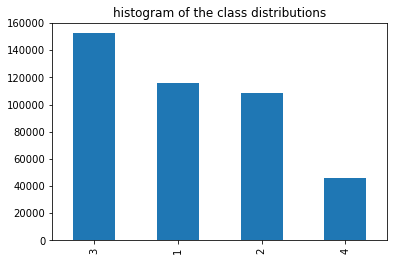

In [19]:
# First let's visualize the class imbalance

dataset['CATEGORY'].value_counts().to_pandas().plot(kind='bar', title='histogram of the class distributions')
dataset['CATEGORY'].value_counts() / len(dataset)

In [252]:
vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
x_train = vec.fit_transform(X_train_text)
x_test = vec.transform(X_test_text)

cnb = ComplementNB()
%time cnb.fit(x_train, y_train)
%time cnb.score(x_test, y_test)

CPU times: user 56.8 ms, sys: 12.3 ms, total: 69.1 ms
Wall time: 69.2 ms
CPU times: user 22.4 ms, sys: 7.27 ms, total: 29.7 ms
Wall time: 29.8 ms


0.9502959251403809

In [253]:
vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
x_train = vec.fit_transform(X_train_text)
x_test = vec.transform(X_test_text)
x_train_np, x_test_np = x_train.get(), x_test.get()
y_train_np, y_test_np = y_train.to_numpy(), y_test.to_numpy()

cnb = ComplementNB_sk()
%time mnb.fit(x_train_np, y_train_np)
%time mnb.score(x_test_np, y_test_np)

CPU times: user 67.5 ms, sys: 31.8 ms, total: 99.3 ms
Wall time: 99.5 ms
CPU times: user 26.6 ms, sys: 11.4 ms, total: 38 ms
Wall time: 37.7 ms


0.9449836611747742

# Categorical

To transform the text to categorical data, you can apply a clustering technique to merge the terms that are similar.

To create these clusters, you could reuse a previously fitted naive Bayes model but just for the purpose of clustering those words.

## Preprocessing

In [14]:
# First fit a TfIdf on the train dataset
tfidfvec = TfidfVectorizer(stop_words='english', min_df=10)
x_train = tfidfvec.fit_transform(X_train_text)

# Fit a Multinomial on the TdIdf data
mnb = MultinomialNB().fit(x_train, y_train)

# Use a KMeans algorithm to cluster on what the Multinomial NB learned of the TfIdf.
# This means that the words that contribute similarly to a category will be clustered together
km = KMeans(n_clusters=1000, random_state=1)
feature_to_cluster = km.fit_predict(mnb.feature_log_prob_.T)
feats2cluster = OneHotEncoder().fit_transform(feature_to_cluster)

# Print statistics on the repartition of the words in the clusters
print(cudf.Series(feats2cluster.sum(0)[0]).describe())

count    1000.000000
mean       14.967000
std        19.519501
min         1.000000
25%         6.000000
50%        11.000000
75%        18.000000
max       254.000000
dtype: float64


Here each cluster holds in average around 15 words

47               117
1597            beam
2114       broadband
2435        carriers
2618         charter
3788       defective
4056            dire
4406            dual
5367           fixes
8365       materials
9072      networking
10900    recognition
11466        rollout
13666        tracker
14088      unveiling
Name: token, dtype: object


3293           core
3603          cyber
4751     enterprise
5719         gaming
8738         models
9801             pc
10074      platform
14338       virtual
Name: token, dtype: object


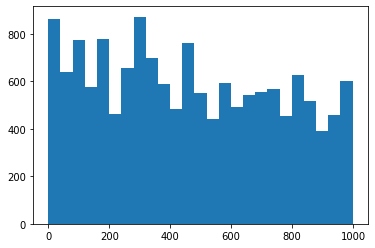

In [225]:
# Lets plot the repartition of the words in each cluster
# And print the words in a few clusters
plt.hist(feature_to_cluster.get(), bins='auto')
print(tfidfvec.vocabulary_[cp.where(feature_to_cluster == 127)[0]])
print("\n")
print(tfidfvec.vocabulary_[cp.where(feature_to_cluster == 632)[0]])

In [226]:
# For Categorical Naive Bayes, the count of words is transformed into a count of cluster
vocab = tfidfvec.vocabulary_
countvec = CountVectorizer(stop_words='english')
countvec.vocabulary_ = vocab

x_train = countvec.transform(X_train_text)
x_test = countvec.transform(X_test_text)
print(x_train.shape)
print(feats2cluster.shape)

x_train_cluster = (x_train @ feats2cluster)
x_test_cluster = (x_test @ feats2cluster)

# For each cluster we will have:
# - 0: absence of those wprds.
# - 1: presence of those words
# - 2: multiple presence of those words (2+)

x_train_cluster.data[x_train_cluster.data > 2] = 2
x_test_cluster.data[x_test_cluster.data > 2] = 2

(316814, 14967)
(14967, 1000)


Little hack to make sure that if a cluster's max number is 1 in training, it is also 1 in testing

In [227]:
max_one = cp.where(x_train_cluster.max(0).todense() == 1)[1]
for cluster in max_one:
    samples = (x_test_cluster[:, cluster] > 1)
    if samples.nnz == 0:
        continue
    samples = cp.where(samples.todense())[0]
    x_test_cluster[samples, cluster] = 1

## Categorical model training

Now that the preprocessing is done we can train the Categorical model and see how it performs on these clusters

In [239]:
%time cnb = CategoricalNB().fit(x_train_cluster, y_train)
%time cnb.score(x_test_cluster, y_test)

/dev/shm/rapids22.04_env/lib/python3.8/site-packages/cuml/naive_bayes/naive_bayes.py:1498: UserWarning: X dtype is not int32. X will be converted, which will increase memory consumption
  warnings.warn("X dtype is not int32. X will be "
/dev/shm/rapids22.04_env/lib/python3.8/site-packages/cupyx/scipy/sparse/compressed.py:545: UserWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  warnings.warn('Changing the sparsity structure of a '
/dev/shm/rapids22.04_env/lib/python3.8/site-packages/cuml/naive_bayes/naive_bayes.py:1516: UserWarning: X dtype is not int32. X will be converted, which will increase memory consumption
  warnings.warn("X dtype is not int32. X will be "


CPU times: user 110 ms, sys: 4.87 ms, total: 115 ms
Wall time: 112 ms
CPU times: user 64.7 ms, sys: 127 ms, total: 191 ms
Wall time: 193 ms


0.9256380200386047

In [240]:
x_train_cluster_np = x_train_cluster.get().todense()
x_test_cluster_np = x_test_cluster.get().todense()
y_train_np, y_test_np = y_train.to_numpy(), y_test.to_numpy()

%time cnb = CategoricalNB_sk().fit(x_train_cluster_np, y_train_np)
%time cnb.score(x_test_cluster_np, y_test_np)

/dev/shm/rapids22.04_env/lib/python3.8/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


CPU times: user 13.7 s, sys: 434 ms, total: 14.2 s
Wall time: 14.2 s


/dev/shm/rapids22.04_env/lib/python3.8/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


CPU times: user 4.4 s, sys: 110 ms, total: 4.51 s
Wall time: 4.51 s


0.9256379906254438

# Performance gain

In [254]:
variants = ['Gaussian', 'Bernoulli', 'Multinomial', 'Complement', 'Categorical']
time_training_cuml = np.array([12300,  26,  63,  69,  112]) / 1000
time_testing_cuml  = np.array([4360,   34,  28,  30,  193])/ 1000
time_training_sk   = np.array([257000, 365, 332, 99, 14200])/ 1000
time_testing_sk    = np.array([316000, 231, 59,  38,  4510])/ 1000
training_gain = time_training_sk / time_training_cuml
testing_gain = time_testing_sk / time_testing_cuml

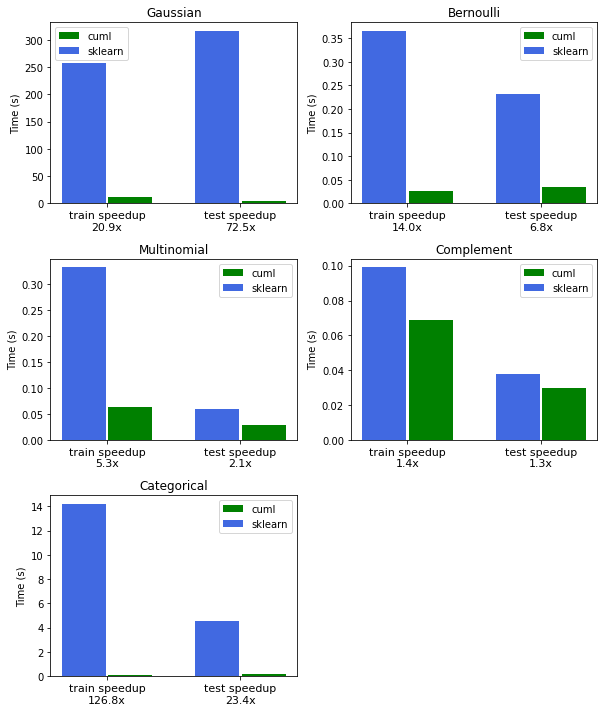

In [256]:
x = np.arange(2)  # the label locations
width = 0.33  # the width of the bars
fig = plt.figure(figsize=(8.5,10))

for i in range(5):
    ax = plt.subplot(3,2,i+1)
    ax.bar(x[0] + width/2 + 0.01, time_training_cuml[i], width, color='green')
    ax.bar(x[0] - width/2 - 0.01, time_training_sk[i], width, color='royalblue')
    ax.bar(x[1] + width/2 + 0.01, time_testing_cuml[i], width, color='green')
    ax.bar(x[1] - width/2 - 0.01, time_testing_sk[i], width, color='royalblue')

    ax.set_ylabel('Time (s)')
    ax.set_title(variants[i])
    ax.set_xticks(x)
    ax.set_xticklabels(["train speedup\n{:.1f}x".format(training_gain[i]),
                        "test speedup\n{:.1f}x".format(testing_gain[i])],
                      fontdict={'fontsize': 11,})
    ax.legend(['cuml', 'sklearn'])

fig.tight_layout()

plt.show()